In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 299
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [93]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(224,224,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

In [56]:
# import training data and combine labels
data_x, data_y  = load_data() 

[1 0 0 0]


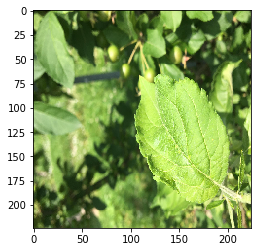

In [57]:
plt.imshow(data_x[15])
print(data_y[15])

[0 0 0 1]


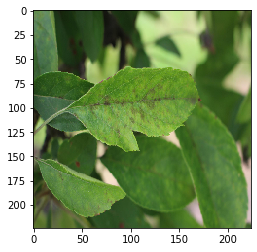

In [58]:
plt.imshow(data_x[0])
print(data_y[0])

[0 0 1 0]


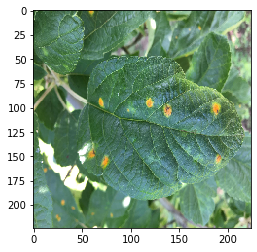

In [59]:
plt.imshow(data_x[5])
print(data_y[5])

## Augmentation

In [60]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [61]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


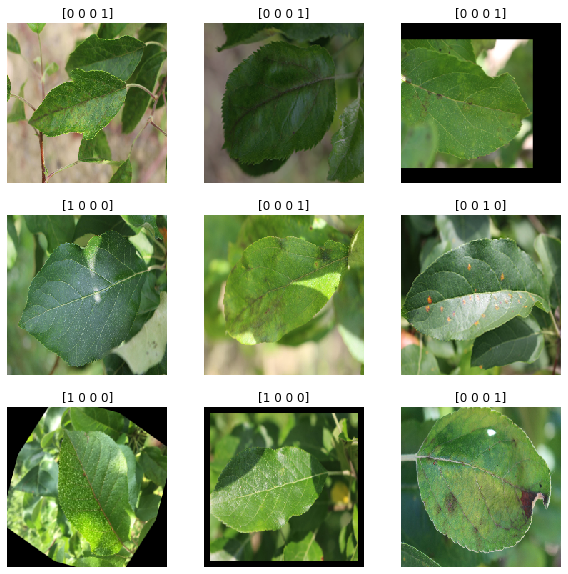

In [62]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [66]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [63]:
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [106]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 6,148
Non-trainable params: 54,336,736
_________________________________________________________________


In [107]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
23/22 [==============================] - 24s 1s/step - loss: 10.8101 - sparse_categorical_crossentropy: 10.8101 - val_loss: 10.4213 - val_sparse_categorical_crossentropy: 10.4213 - lr: 5.0000e-04
Epoch 2/100
23/22 [==============================] - 20s 855ms/step - loss: 10.2339 - sparse_categorical_crossentropy: 10.2339 - val_loss: 9.8122 - val_sparse_categorical_crossentropy: 9.8122 - lr: 5.0000e-04
Epoch 3/100
23/22 [==============================] - 19s 846ms/step - loss: 9.5983 - sparse_categorical_crossentropy: 9.5983 - val_loss: 11.3258 - val_sparse_categorical_crossentropy: 11.3258 - lr: 5.0000e-04
Epoch 4/100
23/22 [==============================] - 20s 861ms/step - loss: 9.6902 - sparse_categorical_crossentropy: 9.6902 - val_loss: 9.2514 - val_sparse_categorical_crossentropy: 9.2514 - lr: 5.0000e-04
Epoch 5/100
23/22 [==============================] - 20s 864ms/step - loss: 9.0206 - sparse_categorical_crossentropy: 9.0206 - val_loss: 9.1706 - val_sparse_categorica

In [108]:
# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
23/22 [==============================] - 60s 3s/step - loss: 1.3516 - accuracy: 0.3200 - val_loss: 1.2462 - val_accuracy: 0.3425 - lr: 1.0000e-04
Epoch 2/200
23/22 [==============================] - 56s 2s/step - loss: 1.2385 - accuracy: 0.3417 - val_loss: 1.2031 - val_accuracy: 0.3836 - lr: 1.0000e-04
Epoch 3/200
23/22 [==============================] - 56s 2s/step - loss: 1.2397 - accuracy: 0.3838 - val_loss: 1.2073 - val_accuracy: 0.3562 - lr: 1.0000e-04
Epoch 4/200
23/22 [==============================] - 57s 2s/step - loss: 1.2028 - accuracy: 0.4022 - val_loss: 1.1173 - val_accuracy: 0.4658 - lr: 1.0000e-04
Epoch 5/200
23/22 [==============================] - 57s 2s/step - loss: 0.9774 - accuracy: 0.5408 - val_loss: 0.8012 - val_accuracy: 0.6685 - lr: 1.0000e-04
Epoch 6/200
23/22 [==============================] - 57s 2s/step - loss: 0.7749 - accuracy: 0.6821 - val_loss: 0.6370 - val_accuracy: 0.7644 - lr: 1.0000e-04
Epoch 7/200
23/22 [==============================] -

In [109]:
model.save('models/InceptionResNetV2')

INFO:tensorflow:Assets written to: models/InceptionResNetV2/assets


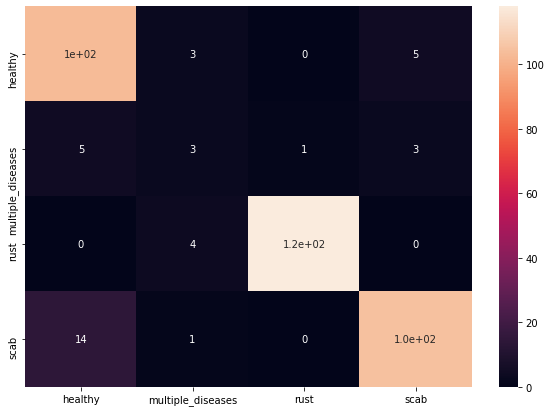

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [111]:
# Train on all data before inference
model.fit(generator(x_val, y_val, batch_size),            
                    epochs=2,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/2
23/22 [==============================] - 51s 2s/step - loss: 0.3151 - accuracy: 0.9029
Epoch 2/2
23/22 [==============================] - 51s 2s/step - loss: 0.2683 - accuracy: 0.9137


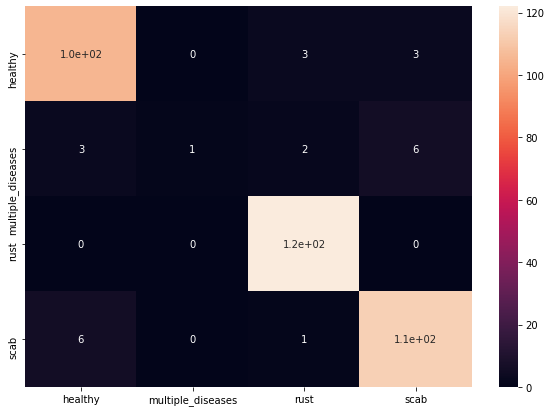

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [113]:
# Load test data and their filename for submission file
test_x, test_id  = load_data("Test") 
test_y = model.predict(test_x)
test_pred = tf.nn.softmax(test_y).numpy()
test_set = np.hstack((test_id, test_pred))
test_set = test_set[test_set[:,1].astype('uint16').argsort()]
test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv('submissions/inceptionResNetv2.csv', index=False)

(1821, 224, 224, 3)


In [149]:
!head submissions/inceptionResNetv2.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,5.7514974e-12,0.0001730654,0.99982697,2.323247e-09
Test_1,7.915399e-15,9.4712275e-05,0.9999052,3.733953e-11
Test_2,3.0540054e-05,0.00095735665,1.14083605e-07,0.999012
Test_3,0.98400855,0.005824261,0.00010073521,0.010066554
Test_4,4.6318958e-09,0.0017486872,0.998251,2.5809166e-07
Test_5,0.11581881,0.29546216,0.38992226,0.19879676
Test_6,0.9934515,0.004461251,0.00016148189,0.0019258015
Test_7,0.009449217,0.35615164,0.56823015,0.06616894
Test_8,0.040627997,0.006508323,2.8139744e-05,0.95283556


In [154]:
!kaggle competitions list -s plant

ref                             deadline             category       reward  teamCount  userHasEntered  
------------------------------  -------------------  ----------  ---------  ---------  --------------  
plant-seedlings-classification  2018-03-12 23:59:00  Playground      Kudos        833            True  
plant-pathology-2020-fgvc7      2020-05-26 23:59:00  Research    Knowledge       1317            True  
herbarium-2020-fgvc7            2020-05-26 23:59:00  Research    Knowledge        153           False  


In [158]:
!kaggle competitions submit -f 'submissions/inceptionResNetv2.csv' -m"inception baseline 20210130" plant-pathology-2020-fgvc7

100%|█████████████████████████████████████████| 103k/103k [00:00<00:00, 142kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

In [159]:
 !kaggle competitions submissions plant-pathology-2020-fgvc7

fileName               date                 description                  status    publicScore  privateScore  
---------------------  -------------------  ---------------------------  --------  -----------  ------------  
inceptionResNetv2.csv  2021-01-31 02:36:15  inception baseline 20210130  complete  0.92493      0.93380       


#### 0.9338 is #801 on leaderboard

## Convert to TFLite

In [160]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/InceptionResNetV2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/InceptionResNetV2.tflite', 'wb') as f:
    f.write(tflite_model)

In [170]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/InceptionResNetV2.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (299,299)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result320====
[[-8.098623  20.280613  32.872677   2.0342734]]
2
====TFLite result====
[[-9.241392  17.788212  24.103294   1.4423556]]
2
====TF Model result936====
[[ 1.759156   3.3063276 -7.695839  10.443231 ]]
3
====TFLite result====
[[ 1.0762084  2.9396756 -4.690091   6.0408373]]
3
====TF Model result471====
[[-4.4430866 10.752027  16.968367   0.971059 ]]
2
====TFLite result====
[[-8.857941  16.679115  22.27221    1.2956066]]
2
====TF Model result205====
[[-6.6743484 16.36166   26.331352   1.2265841]]
2
====TFLite result====
[[-10.058701   18.861298   25.171555    1.3159931]]
2
====TF Model result910====
[[ 0.7219937  2.9152334 -4.7115536  9.597789 ]]
3
====TFLite result====
[[ 0.5466095  3.327868  -2.708939   5.211375 ]]
3
